# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

from sklearn.preprocessing import Imputer, StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans


# magic word for producing visualizations in notebook
%matplotlib inline

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep=';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep=';')

In [3]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).

In [4]:
azdias.shape

(891221, 85)

In [5]:
azdias.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [6]:
azdias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 85 columns):
AGER_TYP                 891221 non-null int64
ALTERSKATEGORIE_GROB     891221 non-null int64
ANREDE_KZ                891221 non-null int64
CJT_GESAMTTYP            886367 non-null float64
FINANZ_MINIMALIST        891221 non-null int64
FINANZ_SPARER            891221 non-null int64
FINANZ_VORSORGER         891221 non-null int64
FINANZ_ANLEGER           891221 non-null int64
FINANZ_UNAUFFAELLIGER    891221 non-null int64
FINANZ_HAUSBAUER         891221 non-null int64
FINANZTYP                891221 non-null int64
GEBURTSJAHR              891221 non-null int64
GFK_URLAUBERTYP          886367 non-null float64
GREEN_AVANTGARDE         891221 non-null int64
HEALTH_TYP               891221 non-null int64
LP_LEBENSPHASE_FEIN      886367 non-null float64
LP_LEBENSPHASE_GROB      886367 non-null float64
LP_FAMILIE_FEIN          886367 non-null float64
LP_FAMILIE_GROB          886367 n

In [7]:
feat_info.head()

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


In [8]:
feat_info

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]
5,FINANZ_SPARER,person,ordinal,[-1]
6,FINANZ_VORSORGER,person,ordinal,[-1]
7,FINANZ_ANLEGER,person,ordinal,[-1]
8,FINANZ_UNAUFFAELLIGER,person,ordinal,[-1]
9,FINANZ_HAUSBAUER,person,ordinal,[-1]


> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [9]:
total_missing_or_unknown = azdias.isnull().sum().sum()
print("Total missing or unknown values: ", total_missing_or_unknown)         

Total missing or unknown values:  4896838


In [10]:
# Identify missing or unknown data values and convert them to NaNs.
for indx in range(len(feat_info)):
    # values = missing or unknown values
    values = feat_info.iloc[indx]['missing_or_unknown']
    values = values.strip('[')
    values = values.strip(']')
    values = values.split(sep=',')
    values = [int(value) if (value!='X' and value!='XX' and value!='') else value for value in values]
    if values != ['']:
        azdias = azdias.replace({feat_info.iloc[indx]['attribute']: values}, np.nan)

In [11]:
total_missing_or_unknown = azdias.isnull().sum().sum()
print("Total missing or unknown values: ", total_missing_or_unknown)

Total missing or unknown values:  8373929


#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [12]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.
missing_values_per_col= azdias.isnull().sum()

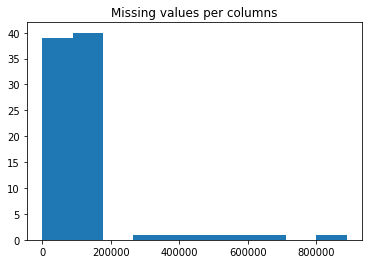

In [13]:
# Investigate patterns in the amount of missing data in each column.
plt.hist(missing_values_per_col)
plt.title(s='Missing values per columns')
plt.show()

In [14]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)
missing_data = pd.DataFrame({'attribute': missing_values_per_col.index, 'value': missing_values_per_col.values})

missing_data_over_200 = missing_data[missing_data['value']>200000]      
missing_data_over_200 = list(missing_data_over_200.attribute)

print('Outlier columns with missing data over two hundred thousands are: ', missing_data_over_200)

Outlier columns with missing data over two hundred thousands are:  ['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP', 'KBA05_BAUMAX']


In [15]:
azdias = azdias.drop(missing_data_over_200, axis=1)

In [16]:
azdias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 79 columns):
ALTERSKATEGORIE_GROB     888340 non-null float64
ANREDE_KZ                891221 non-null int64
CJT_GESAMTTYP            886367 non-null float64
FINANZ_MINIMALIST        891221 non-null int64
FINANZ_SPARER            891221 non-null int64
FINANZ_VORSORGER         891221 non-null int64
FINANZ_ANLEGER           891221 non-null int64
FINANZ_UNAUFFAELLIGER    891221 non-null int64
FINANZ_HAUSBAUER         891221 non-null int64
FINANZTYP                891221 non-null int64
GFK_URLAUBERTYP          886367 non-null float64
GREEN_AVANTGARDE         891221 non-null int64
HEALTH_TYP               780025 non-null float64
LP_LEBENSPHASE_FEIN      793589 non-null float64
LP_LEBENSPHASE_GROB      796649 non-null float64
LP_FAMILIE_FEIN          813429 non-null float64
LP_FAMILIE_GROB          813429 non-null float64
LP_STATUS_FEIN           886367 non-null float64
LP_STATUS_GROB           

#### Discussion 1.1.2: Assess Missing Data in Each Column
*Most feature have missing values less than two hundred thousands, except some outliers. The outlier columns which were removed from the data are: 'AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP', and 'KBA05_BAUMAX'.*

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [17]:
# How much data is missing in each row of the dataset?
missing_values_per_row= azdias.isnull().sum(axis=1)

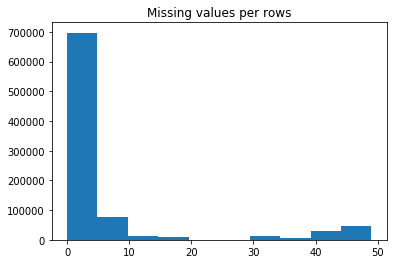

In [18]:
plt.hist(missing_values_per_row)
plt.title(s='Missing values per rows')
plt.show()

In [19]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.
azdias_below_threshold = azdias[missing_values_per_row <= 10]
azdias_above_threshold = azdias[missing_values_per_row > 10]

In [20]:
azdias_below_threshold.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 780153 entries, 1 to 891220
Data columns (total 79 columns):
ALTERSKATEGORIE_GROB     777528 non-null float64
ANREDE_KZ                780153 non-null int64
CJT_GESAMTTYP            776319 non-null float64
FINANZ_MINIMALIST        780153 non-null int64
FINANZ_SPARER            780153 non-null int64
FINANZ_VORSORGER         780153 non-null int64
FINANZ_ANLEGER           780153 non-null int64
FINANZ_UNAUFFAELLIGER    780153 non-null int64
FINANZ_HAUSBAUER         780153 non-null int64
FINANZTYP                780153 non-null int64
GFK_URLAUBERTYP          776319 non-null float64
GREEN_AVANTGARDE         780153 non-null int64
HEALTH_TYP               745629 non-null float64
LP_LEBENSPHASE_FEIN      733579 non-null float64
LP_LEBENSPHASE_GROB      736259 non-null float64
LP_FAMILIE_FEIN          751303 non-null float64
LP_FAMILIE_GROB          751303 non-null float64
LP_STATUS_FEIN           776319 non-null float64
LP_STATUS_GROB           

In [21]:
azdias_above_threshold.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 111068 entries, 0 to 891203
Data columns (total 79 columns):
ALTERSKATEGORIE_GROB     110812 non-null float64
ANREDE_KZ                111068 non-null int64
CJT_GESAMTTYP            110048 non-null float64
FINANZ_MINIMALIST        111068 non-null int64
FINANZ_SPARER            111068 non-null int64
FINANZ_VORSORGER         111068 non-null int64
FINANZ_ANLEGER           111068 non-null int64
FINANZ_UNAUFFAELLIGER    111068 non-null int64
FINANZ_HAUSBAUER         111068 non-null int64
FINANZTYP                111068 non-null int64
GFK_URLAUBERTYP          110048 non-null float64
GREEN_AVANTGARDE         111068 non-null int64
HEALTH_TYP               34396 non-null float64
LP_LEBENSPHASE_FEIN      60010 non-null float64
LP_LEBENSPHASE_GROB      60390 non-null float64
LP_FAMILIE_FEIN          62126 non-null float64
LP_FAMILIE_GROB          62126 non-null float64
LP_STATUS_FEIN           110048 non-null float64
LP_STATUS_GROB           11004

In [22]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.
def compare(column):
    plt.figure()
    fig, ax = plt.subplots(1,2)
    fig.tight_layout()
    plt.figure(figsize=(20,6))
    sns.set(style="darkgrid")
    sns.FacetGrid
    sns.countplot(azdias_below_threshold[column], ax=ax[0])
    sns.countplot(azdias_above_threshold[column], ax=ax[1])
    plt.show()

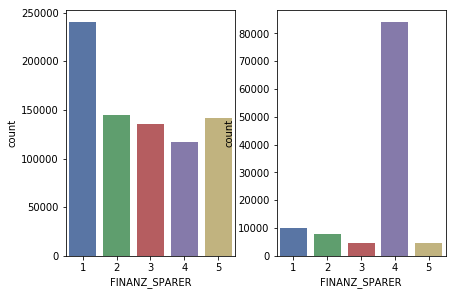

In [23]:
compare('FINANZ_SPARER')

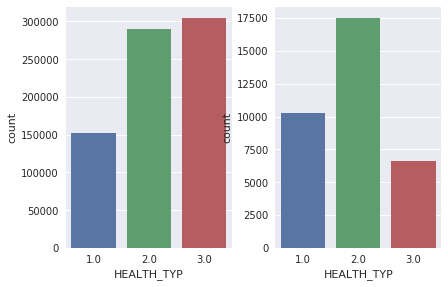

In [24]:
compare('HEALTH_TYP')

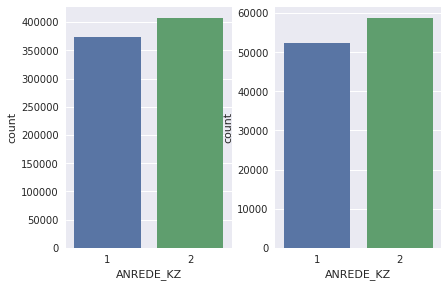

In [25]:
compare('ANREDE_KZ')

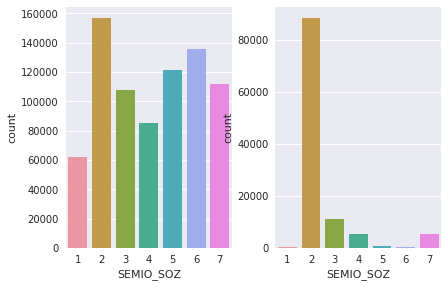

In [26]:
compare('SEMIO_SOZ')

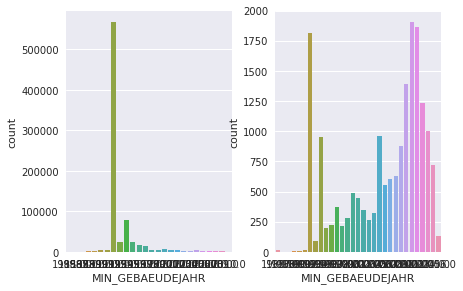

In [27]:
compare('MIN_GEBAEUDEJAHR')

#### Discussion 1.1.3: Assess Missing Data in Each Row

Most rows have missing data equal or less than 10, rows with missing data over 10 recognized as outliers. Data divided into to classes with the number 10 as the threshold. As shown above, features distribution is different between data with few or no missing data and data with lots of missing data, thus they have different qualities.

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [28]:
# How many features are there of each data type?
## Count for data with no or few missing values

In [29]:
feat_info['type'].value_counts()

ordinal        49
categorical    21
numeric         7
mixed           7
interval        1
Name: type, dtype: int64

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [30]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?

In [31]:
cat_feat_info= feat_info[feat_info['type']=='categorical']
cat_feat= cat_feat_info['attribute'].tolist()

In [32]:
for col in azdias_below_threshold.columns:
    if col in cat_feat:
        print(azdias_below_threshold[col].value_counts())

2    406643
1    373510
Name: ANREDE_KZ, dtype: int64
4.0    193491
3.0    143625
2.0    139638
5.0    109291
6.0     98948
1.0     91326
Name: CJT_GESAMTTYP, dtype: int64
6    286945
1    192639
5    104605
2    102294
4     55044
3     38626
Name: FINANZTYP, dtype: int64
12.0    125499
10.0    101312
8.0      81841
11.0     73887
5.0      69843
4.0      60146
9.0      55670
3.0      52892
1.0      50114
7.0      40008
2.0      39613
6.0      25494
Name: GFK_URLAUBERTYP, dtype: int64
0    608462
1    171691
Name: GREEN_AVANTGARDE, dtype: int64
1.0     395060
10.0    127197
2.0      96151
11.0     48219
8.0      21321
7.0      18691
4.0      11244
5.0      10975
9.0      10285
6.0       7762
3.0       4398
Name: LP_FAMILIE_FEIN, dtype: int64
1.0    395060
5.0    185701
2.0     96151
4.0     47774
3.0     26617
Name: LP_FAMILIE_GROB, dtype: int64
1.0     204772
9.0     131071
2.0     109934
10.0    109300
4.0      73272
3.0      68384
6.0      28227
5.0      26343
8.0      15977
7.0    

In [33]:
# Re-encode categorical variable(s) to be kept in the analysis.

In [34]:
# create dummy variables for 'OST_WEST_KZ' and drop the original column
dummy = pd.get_dummies(azdias_below_threshold['OST_WEST_KZ'])
dummy = dummy.rename(columns={'W': 'OST_WEST_KZ_W', 'O': 'OST_WEST_KZ_O'})
azdias_below_threshold = pd.concat([azdias_below_threshold, dummy], axis=1)
azdias_below_threshold.drop('OST_WEST_KZ', axis=1, inplace=True)

In [35]:
# Drop all columns with multi-level categories
azdias_below_threshold.drop(columns=['CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'ZABEOTYP',  'GEBAEUDETYP', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015'], axis=1,inplace=True)

In [36]:
azdias_below_threshold.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 780153 entries, 1 to 891220
Data columns (total 67 columns):
ALTERSKATEGORIE_GROB     777528 non-null float64
ANREDE_KZ                780153 non-null int64
FINANZ_MINIMALIST        780153 non-null int64
FINANZ_SPARER            780153 non-null int64
FINANZ_VORSORGER         780153 non-null int64
FINANZ_ANLEGER           780153 non-null int64
FINANZ_UNAUFFAELLIGER    780153 non-null int64
FINANZ_HAUSBAUER         780153 non-null int64
GREEN_AVANTGARDE         780153 non-null int64
HEALTH_TYP               745629 non-null float64
LP_LEBENSPHASE_FEIN      733579 non-null float64
LP_LEBENSPHASE_GROB      736259 non-null float64
PRAEGENDE_JUGENDJAHRE    753679 non-null float64
RETOURTYP_BK_S           776319 non-null float64
SEMIO_SOZ                780153 non-null int64
SEMIO_FAM                780153 non-null int64
SEMIO_REL                780153 non-null int64
SEMIO_MAT                780153 non-null int64
SEMIO_VERT               780153

#### Discussion 1.2.1: Re-Encode Categorical Features

Binary level categories kept without change, except 'OST_WEST_KZ' where I created dummy variables, because it does not use numerical values. Multi-level categories were dropped from the data.

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [37]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
azdias_below_threshold['PRAEGENDE_JUGENDJAHRE'].value_counts()

14.0    178410
8.0     138678
10.0     83881
5.0      83645
3.0      53098
15.0     41029
11.0     34642
9.0      33197
6.0      25517
12.0     24034
4.0      20343
1.0      20242
2.0       7438
13.0      5561
7.0       3964
Name: PRAEGENDE_JUGENDJAHRE, dtype: int64

In [38]:
'''
generation values will be encoded in this way
1: 40s
2: 50s
3: 60s
4: 70s
5: 80s
6: 90s
'''
generation_dect={1:1, 2:1,
                 3:2, 4:2, 5:2,
                 5:3, 6:3, 7:3,
                 8:4, 9:4,
                 10:5, 11:5, 12:5, 13:5,
                 14:6, 15:6}
azdias_below_threshold['generation'] = azdias_below_threshold['PRAEGENDE_JUGENDJAHRE']
azdias_below_threshold['generation'].replace(generation_dect, inplace=True)
azdias_below_threshold['generation'] = azdias_below_threshold['generation'].astype('category')

In [39]:
azdias_below_threshold['generation'].value_counts()

6.0    219439
4.0    171875
5.0    148118
3.0    113126
2.0     73441
1.0     27680
Name: generation, dtype: int64

In [41]:
'''
movement will be encoded in this way:
1: Avantgarde
2: Mainstream
'''
movement_dect={1:2, 2:1, 3:2, 4:1, 5:2, 6:1, 7:1, 8:2, 9:1, 10:2, 11:1, 12:2, 13:1, 14:2, 15:1}
azdias_below_threshold['movement']= azdias_below_threshold['PRAEGENDE_JUGENDJAHRE']
azdias_below_threshold['movement'].replace(movement_dect, inplace=True)
azdias_below_threshold['movement'] = azdias_below_threshold['movement'].astype('category')

In [42]:
# Drop the original column
azdias_below_threshold.drop('PRAEGENDE_JUGENDJAHRE', axis=1, inplace=True)

In [43]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.
azdias_below_threshold['CAMEO_INTL_2015'].value_counts()

51    132853
41     91071
24     89200
14     61422
43     55836
54     45004
25     38860
22     32235
45     25771
13     25659
23     24280
55     23609
52     20388
34     18237
31     17853
15     16735
44     14593
12     12890
35     10212
32     10153
33      9636
Name: CAMEO_INTL_2015, dtype: int64

In [44]:
azdias_below_threshold['wealth']= azdias_below_threshold['CAMEO_INTL_2015']
azdias_below_threshold['life_stage'] = azdias_below_threshold['CAMEO_INTL_2015']

In [45]:
azdias_below_threshold['CAMEO_INTL_2015'].dtypes

dtype('O')

In [46]:
'''
Wealth will be encoded in this way:   
1: Wealthy Households   
2: Prosperous Households   
3: Comfortable Households   
4: Less Affluent Households   
5: Poorer Households  
'''
wealth_dect = {'11':1, '12':1, '13':1, '14':1, '15':1,
              '21':2, '22':2, '23':2, '24':2, '25':2,
              '31':3, '32':3, '33':3, '34':3, '35':3,
              '41':4, '42':4, '43':4, '44':4, '45':4,
              '51':5, '52':5, '53':5, '54':5, '55':5}
azdias_below_threshold['wealth'].replace(wealth_dect, inplace=True)
azdias_below_threshold['wealth'] = azdias_below_threshold['wealth'].astype('category')

In [47]:
azdias_below_threshold['wealth'].value_counts()

5.0    221854
4.0    187271
2.0    184575
1.0    116706
3.0     66091
Name: wealth, dtype: int64

In [48]:
'''
Life stage will be encoded in this way:
1: Pre-Family Couples & Singles
2: Young Couples With Children
3: Families With School Age Children
4: Older Families &  Mature Couples
5: Elders In Retirement
'''
life_dect = {'11':1, '21':1, '31':1, '41':1, '51':1,
            '12':2, '22':2, '32':2, '42':2, '52':2,
            '13':3, '23':3, '33':3, '43':3, '53':3,
            '14':4, '24':4, '34':4, '44':4, '54':4,
            '15':5, '25':5, '35':5, '45':5, '55':5}
azdias_below_threshold['life_stage'].replace(life_dect, inplace=True)
azdias_below_threshold['life_stage'] = azdias_below_threshold['life_stage'].astype('category')

In [49]:
azdias_below_threshold['life_stage'].value_counts()

1.0    241777
4.0    228456
3.0    115411
5.0    115187
2.0     75666
Name: life_stage, dtype: int64

In [50]:
#Drop the original column
azdias_below_threshold.drop('CAMEO_INTL_2015', axis=1, inplace=True)

In [51]:
# Drop remaining mixed features
azdias_below_threshold.drop(['PLZ8_BAUMAX', 'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB'] , axis=1, inplace=True)

In [52]:
azdias_below_threshold.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 780153 entries, 1 to 891220
Data columns (total 66 columns):
ALTERSKATEGORIE_GROB     777528 non-null float64
ANREDE_KZ                780153 non-null int64
FINANZ_MINIMALIST        780153 non-null int64
FINANZ_SPARER            780153 non-null int64
FINANZ_VORSORGER         780153 non-null int64
FINANZ_ANLEGER           780153 non-null int64
FINANZ_UNAUFFAELLIGER    780153 non-null int64
FINANZ_HAUSBAUER         780153 non-null int64
GREEN_AVANTGARDE         780153 non-null int64
HEALTH_TYP               745629 non-null float64
RETOURTYP_BK_S           776319 non-null float64
SEMIO_SOZ                780153 non-null int64
SEMIO_FAM                780153 non-null int64
SEMIO_REL                780153 non-null int64
SEMIO_MAT                780153 non-null int64
SEMIO_VERT               780153 non-null int64
SEMIO_LUST               780153 non-null int64
SEMIO_ERL                780153 non-null int64
SEMIO_KULT               780153 non-n

In [53]:
azdias_below_threshold.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,OST_WEST_KZ_O,OST_WEST_KZ_W,generation,movement,wealth,life_stage
1,1.0,2,1,5,2,5,4,5,0,3.0,...,4.0,3.0,5.0,4.0,0,1,6.0,2.0,5.0,1.0
2,3.0,2,1,4,1,2,3,5,1,3.0,...,4.0,3.0,5.0,2.0,0,1,6.0,1.0,2.0,4.0
3,4.0,2,4,2,5,2,1,2,0,2.0,...,4.0,2.0,3.0,3.0,0,1,4.0,2.0,1.0,2.0
4,3.0,1,4,3,4,1,3,2,0,3.0,...,3.0,4.0,6.0,5.0,0,1,4.0,2.0,4.0,3.0
5,1.0,2,3,1,5,2,2,5,0,3.0,...,5.0,2.0,3.0,3.0,0,1,2.0,2.0,5.0,4.0


#### Discussion 1.2.2: Engineer Mixed-Type Features

In regard to mixed type features 'PRAEGENDE_JUGENDJAHRE' and 'CAMEO_INTL_2015' were encoded. Other mixed features were dropped.


#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [54]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.
azdias_below_threshold.columns

Index(['ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'FINANZ_MINIMALIST',
       'FINANZ_SPARER', 'FINANZ_VORSORGER', 'FINANZ_ANLEGER',
       'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER', 'GREEN_AVANTGARDE',
       'HEALTH_TYP', 'RETOURTYP_BK_S', 'SEMIO_SOZ', 'SEMIO_FAM', 'SEMIO_REL',
       'SEMIO_MAT', 'SEMIO_VERT', 'SEMIO_LUST', 'SEMIO_ERL', 'SEMIO_KULT',
       'SEMIO_RAT', 'SEMIO_KRIT', 'SEMIO_DOM', 'SEMIO_KAEM', 'SEMIO_PFLICHT',
       'SEMIO_TRADV', 'SOHO_KZ', 'VERS_TYP', 'ANZ_PERSONEN', 'ANZ_TITEL',
       'HH_EINKOMMEN_SCORE', 'W_KEIT_KIND_HH', 'WOHNDAUER_2008',
       'ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 'KONSUMNAEHE',
       'MIN_GEBAEUDEJAHR', 'WOHNLAGE', 'KBA05_ANTG1', 'KBA05_ANTG2',
       'KBA05_ANTG3', 'KBA05_ANTG4', 'KBA05_GBZ', 'BALLRAUM', 'EWDICHTE',
       'INNENSTADT', 'GEBAEUDETYP_RASTER', 'KKK', 'MOBI_REGIO',
       'ONLINE_AFFINITAET', 'REGIOTYP', 'KBA13_ANZAHL_PKW', 'PLZ8_ANTG1',
       'PLZ8_ANTG2', 'PLZ8_ANTG3', 'PLZ8_ANTG4', 'PLZ8_HHZ', 'PLZ8_GBZ',
       'ARBEIT',

### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [57]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep=';')

    # Identify missing or unknown data values and convert them to NaNs.
    for indx in range(len(feat_info)):
        # values = missing or unknown values
        values = feat_info.iloc[indx]['missing_or_unknown']
        values = values.strip('[')
        values = values.strip(']')
        values = values.split(sep=',')
        values = [int(value) if (value!='X' and value!='XX' and value!='') else value for value in values]
        if values != ['']:
            df = df.replace({feat_info.iloc[indx]['attribute']: values}, np.nan)
    
    # Perform an assessment of how much missing data there is in each column of the
    # dataset.
    missing_values_per_col= df.isnull().sum()
    missing_data = pd.DataFrame({'attribute': missing_values_per_col.index, 'value': missing_values_per_col.values})
    missing_data_over_200 = missing_data[missing_data['value']>200000]      
    missing_data_over_200 = list(missing_data_over_200.attribute)
    df = df.drop(missing_data_over_200, axis=1)

    
    # Re-Encode Categorical Features
    df_below_threshold = df[missing_values_per_row <= 10]
    df_above_threshold = df[missing_values_per_row > 10]
    cat_feat_info= feat_info[feat_info['type']=='categorical']
    cat_feat= cat_feat_info['attribute'].tolist()
    
    for col in df_below_threshold.columns:
        if col in cat_feat:
            print(df_below_threshold[col].value_counts())
     
    # create dummy variables for 'OST_WEST_KZ' and drop the original column
    dummy = pd.get_dummies(df_below_threshold['OST_WEST_KZ'])
    dummy = dummy.rename(columns={'W': 'OST_WEST_KZ_W', 'O': 'OST_WEST_KZ_O'})
    df_below_threshold = pd.concat([df_below_threshold, dummy], axis=1)
    df_below_threshold.drop('OST_WEST_KZ', axis=1, inplace=True)
    
    # Drop all columns with multi-level categories
    df_below_threshold.drop(columns=['CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP',
                                         'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN',
                                         'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'ZABEOTYP',
                                         'GEBAEUDETYP', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015'], inplace=True)
    # Engineer Mixed-Type Features
    generation_dect={1:1, 2:1,
                 3:2, 4:2, 5:2,
                 5:3, 6:3, 7:3,
                 8:4, 9:4,
                 10:5, 11:5, 12:5, 13:5,
                 14:6, 15:6}
    df_below_threshold['generation'] = df_below_threshold['PRAEGENDE_JUGENDJAHRE']
    df_below_threshold['generation'].replace(generation_dect, inplace=True)
    df_below_threshold['generation'] = df_below_threshold['generation'].astype('category')
    
    movement_dect={1:2, 2:1, 3:2, 4:1, 5:2, 6:1, 7:1, 8:2, 9:1, 10:2, 11:1, 12:2, 13:1, 14:2, 15:1}
    df_below_threshold['movement']= df_below_threshold['PRAEGENDE_JUGENDJAHRE']
    df_below_threshold['movement'].replace(movement_dect, inplace=True)
    df_below_threshold['movement'] = df_below_threshold['movement'].astype('category')


    
    df_below_threshold['wealth']= df_below_threshold['CAMEO_INTL_2015']
    df_below_threshold['life_stage'] = df_below_threshold['CAMEO_INTL_2015']
    
    wealth_dect = {'11':1, '12':1, '13':1, '14':1, '15':1,
              '21':2, '22':2, '23':2, '24':2, '25':2,
              '31':3, '32':3, '33':3, '34':3, '35':3,
              '41':4, '42':4, '43':4, '44':4, '45':4,
              '51':5, '52':5, '53':5, '54':5, '55':5}
    df_below_threshold['wealth'].replace(wealth_dect, inplace=True)
    df_below_threshold['wealth'] = df_below_threshold['wealth'].astype('category')

    
    life_dect = {'11':1, '21':1, '31':1, '41':1, '51':1,
            '12':2, '22':2, '32':2, '42':2, '52':2,
            '13':3, '23':3, '33':3, '43':3, '53':3,
            '14':4, '24':4, '34':4, '44':4, '54':4,
            '15':5, '25':5, '35':5, '45':5, '55':5}
    df_below_threshold['life_stage'].replace(life_dect, inplace=True)
    df_below_threshold['life_stage'] = df_below_threshold['life_stage'].astype('category')
                                             
                                             
    # Drop original columns before encoding and remaining mixed type features
    df_below_threshold.drop(['PRAEGENDE_JUGENDJAHRE', 'CAMEO_INTL_2015', 'PLZ8_BAUMAX', 'LP_LEBENSPHASE_FEIN',
                             'LP_LEBENSPHASE_GROB'] , axis=1, inplace=True)

    return df_below_threshold

In [58]:
df = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep=';')
azdias = clean_data(df)

2    406643
1    373510
Name: ANREDE_KZ, dtype: int64
4.0    193491
3.0    143625
2.0    139638
5.0    109291
6.0     98948
1.0     91326
Name: CJT_GESAMTTYP, dtype: int64
6    286945
1    192639
5    104605
2    102294
4     55044
3     38626
Name: FINANZTYP, dtype: int64
12.0    125499
10.0    101312
8.0      81841
11.0     73887
5.0      69843
4.0      60146
9.0      55670
3.0      52892
1.0      50114
7.0      40008
2.0      39613
6.0      25494
Name: GFK_URLAUBERTYP, dtype: int64
0    608462
1    171691
Name: GREEN_AVANTGARDE, dtype: int64
1.0     395060
10.0    127197
2.0      96151
11.0     48219
8.0      21321
7.0      18691
4.0      11244
5.0      10975
9.0      10285
6.0       7762
3.0       4398
Name: LP_FAMILIE_FEIN, dtype: int64
1.0    395060
5.0    185701
2.0     96151
4.0     47774
3.0     26617
Name: LP_FAMILIE_GROB, dtype: int64
1.0     204772
9.0     131071
2.0     109934
10.0    109300
4.0      73272
3.0      68384
6.0      28227
5.0      26343
8.0      15977
7.0    

In [59]:
azdias.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 780153 entries, 1 to 891220
Data columns (total 66 columns):
ALTERSKATEGORIE_GROB     777528 non-null float64
ANREDE_KZ                780153 non-null int64
FINANZ_MINIMALIST        780153 non-null int64
FINANZ_SPARER            780153 non-null int64
FINANZ_VORSORGER         780153 non-null int64
FINANZ_ANLEGER           780153 non-null int64
FINANZ_UNAUFFAELLIGER    780153 non-null int64
FINANZ_HAUSBAUER         780153 non-null int64
GREEN_AVANTGARDE         780153 non-null int64
HEALTH_TYP               745629 non-null float64
RETOURTYP_BK_S           776319 non-null float64
SEMIO_SOZ                780153 non-null int64
SEMIO_FAM                780153 non-null int64
SEMIO_REL                780153 non-null int64
SEMIO_MAT                780153 non-null int64
SEMIO_VERT               780153 non-null int64
SEMIO_LUST               780153 non-null int64
SEMIO_ERL                780153 non-null int64
SEMIO_KULT               780153 non-n

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [60]:
azdias.isnull().sum().sum()

529094

In [61]:
# Replace missing values with most frequent value
imputer = Imputer(strategy='most_frequent')
azdias_imputed = imputer.fit_transform(azdias)
azdias_imputed = pd.DataFrame(azdias_imputed)
azdias_imputed.index = azdias.index
azdias_imputed.columns = azdias_imputed.columns

In [62]:
# Apply feature scaling to the general population demographics data.
scaler = StandardScaler()
azdias_scaled = scaler.fit_transform(azdias_imputed)
azdias_scaled = pd.DataFrame(azdias_scaled)
azdias_scaled.index = azdias.index
azdias_scaled.columns = azdias.columns

### Discussion 2.1: Apply Feature Scaling

Missing values replaced with most frequent value in each column then values standardized using standard scaler.

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [63]:
# Apply PCA to the data.
pca = PCA()
azdias_pca = pca.fit_transform(azdias_scaled)

In [64]:
def scree_plot(pca):
    '''
    Creates a scree plot associated with the principal components 
    
    INPUT: pca - the result of instantian of PCA in scikit learn
            
    OUTPUT:
            None
    '''
    num_components=len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
 
    plt.figure(figsize=(10, 6))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
    for i in range(num_components):
        ax.annotate(r"%s%%" % ((str(vals[i]*100)[:4])), (ind[i]+0.2, vals[i]), va="bottom", ha="center", fontsize=12)
 
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')

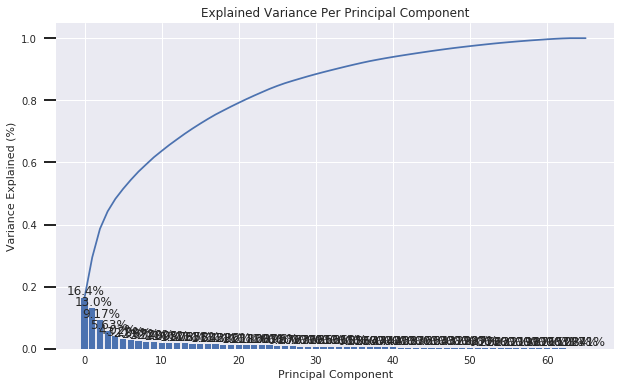

In [65]:
# Investigate the variance accounted for by each principal component.
scree_plot(pca)

In [66]:
pca_ex = pca.explained_variance_ratio_
total_val  = 0
for indx, val in enumerate(pca_ex):
    total_val = total_val+val
    if total_val > 0.9:
        print(indx)
        print(total_val)
        break

33
0.903285326233


In [67]:
# Re-apply PCA to the data while selecting for number of components to retain.
pca_33 = PCA(n_components= 33)
azdias_pca = pca_33.fit_transform(azdias_scaled)

### Discussion 2.2: Perform Dimensionality Reduction


I chose to retain 33 principal components because it give over 90% explained variance.

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [68]:
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.
def pca_results(full_dataset, pca):
    '''
    Create a DataFrame of the PCA results
    Includes dimension feature weights and explained variance
    Visualizes the PCA results
    '''

    # Dimension indexing
    dimensions = dimensions = ['PC {}'.format(i) for i in range(1,len(pca.components_)+1)]

    # PCA components
    components = pd.DataFrame(np.round(pca.components_, 4), columns = full_dataset.keys())
    components.index = dimensions
  
    return components

In [69]:
pca_weights=pca_results(azdias, pca_33)
pca_weights.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,OST_WEST_KZ_O,OST_WEST_KZ_W,generation,movement,wealth,life_stage
PC 1,-0.1167,0.0085,-0.2179,0.1440,-0.1130,0.0670,0.0732,0.1626,-0.1075,0.0380,...,-0.1680,0.1468,0.2009,0.1366,0.0586,-0.0586,0.1040,0.1075,0.2048,-0.1227
PC 2,0.2604,0.0908,0.0701,-0.2373,0.2326,-0.2069,-0.2277,0.1131,-0.0102,-0.0592,...,-0.0702,0.0679,0.0918,0.0645,0.0275,-0.0275,-0.2428,0.0102,0.0696,0.0045
PC 3,0.0783,-0.3682,0.1569,-0.1061,0.0995,-0.1900,-0.0993,-0.0445,0.0519,-0.0301,...,-0.0396,0.0373,0.0504,0.0331,0.0182,-0.0182,-0.1101,-0.0519,0.0263,-0.0079
PC 4,-0.0475,0.0322,0.0524,0.0031,-0.0008,-0.1235,0.0984,-0.1057,0.3651,0.0107,...,0.0685,0.0247,0.2382,0.0954,-0.1905,0.1905,0.0314,-0.3651,-0.1183,0.0538
PC 5,-0.0114,0.0256,0.0832,-0.0132,-0.1047,0.0459,-0.0769,-0.0463,0.1322,-0.0298,...,-0.3105,0.2447,0.0900,0.0887,0.4021,-0.4021,0.0172,-0.1322,-0.0492,0.0781


In [70]:
pca_weights.shape

(33, 66)

In [71]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
pc1 = pca_weights.iloc[0,:]
pc1_sorted = pc1.sort_values(ascending=False)
print(pc1_sorted.head())
print(pc1_sorted.tail())

PLZ8_ANTG3            0.2275
PLZ8_ANTG4            0.2193
wealth                0.2048
HH_EINKOMMEN_SCORE    0.2010
ORTSGR_KLS9           0.2009
Name: PC 1, dtype: float64
KBA05_GBZ           -0.2161
KBA05_ANTG1         -0.2167
FINANZ_MINIMALIST   -0.2179
PLZ8_ANTG1          -0.2269
MOBI_REGIO          -0.2290
Name: PC 1, dtype: float64


In [72]:
### Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.
pc2 = pca_weights.iloc[1,:]
pc2_sorted = pc2.sort_values(ascending=False)
print(pc2_sorted.head())
print(pc2_sorted.tail())

ALTERSKATEGORIE_GROB    0.2604
FINANZ_VORSORGER        0.2326
SEMIO_ERL               0.2312
SEMIO_LUST              0.1820
RETOURTYP_BK_S          0.1629
Name: PC 2, dtype: float64
SEMIO_PFLICHT   -0.2311
SEMIO_TRADV     -0.2312
FINANZ_SPARER   -0.2373
generation      -0.2428
SEMIO_REL       -0.2579
Name: PC 2, dtype: float64


In [73]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.
pc3 = pca_weights.iloc[2,:]
pc3_sorted = pc3.sort_values(ascending=False)
print(pc3_sorted.head())
print(pc3_sorted.tail())

SEMIO_VERT           0.3465
SEMIO_SOZ            0.2633
SEMIO_FAM            0.2493
SEMIO_KULT           0.2336
FINANZ_MINIMALIST    0.1569
Name: PC 3, dtype: float64
SEMIO_RAT    -0.2166
SEMIO_KRIT   -0.2742
SEMIO_DOM    -0.3124
SEMIO_KAEM   -0.3362
ANREDE_KZ    -0.3682
Name: PC 3, dtype: float64


### Discussion 2.3: Interpret Principal Components


####  The First component:    
1. Positive relation with:     
1.1 PLZ8_ANTG3: Number of 6-10 family houses in the PLZ8 region.   
1.2 PLZ8_ANTG4: Number of 10+ family houses in the PLZ8 region.   
1.3 Wealth: Wealth of household.    
1.4 HH_EINKOMMEN_SCORE: Estimated household net income.    
1.5 ORTSGR_KLS9: Size of community. 

   
2. Negative relation with:   
2.1 KBA05_GBZ: Number of buildings in the microcell.   
2.2 KBA05_ANTG1: Number of 1-2 family houses in the microcell.   
2.3 FINANZ_MINIMALIST: Has low financial interest.   
2.4 PLZ8_ANTG1: Number of 1-2 family houses in the PLZ8 region.   
2.5 MOBI_REGIO: Movement patterns.   

The first component have relation with financial status and population density.   

#### The Second component:
1. Positive relation with:     
1.1 ALTERSKATEGORIE_GROB: Estimated age based on given name analysis.   
1.2 FINANZ_VORSORGER: be prepared financially.   
1.3 SEMIO_ERL: Event-oriented personality.   
1.4 SEMIO_LUST: Sensual-minded personality.   
1.5 RETOURTYP_BK_S: Return type.    

2. Negative relation with:  
2.1 SEMIO_PFLICHT: Dutiful personality.    
2.2 SEMIO_TRADV: Traditional-minded personality.   
2.3 FINANZ_SPARER: Financially: Money-saver.    
2.4 Generation: Born into which generation.   
2.5 SEMIO_REL: Religious personality.

The second component is related to people age and personality.    

#### The Third component:
1. Positive relation with:     
1.1 SEMIO_VERT: Dreamful personality.   
1.2 SEMIO_SOZ: Socially-minded personality.   
1.3 SEMIO_FAM: Family-minded personality.   
1.4 SEMIO_KULT: Cultural-minded personality.   
1.5 FINANZ_MINIMALIST: Has low financial interest.

2. Negative relation with:  
2.1 SEMIO_RAT: Rational personality.   
2.2 SEMIO_KRIT: Critical-minded personality.   
2.3 SEMIO_DOM: Dominant-minded personality.   
2.4 SEMIO_KAEM: Combative attitude personality.   
2.5 ANREDE_KZ: Gender.   

The third component is related to personality and gender.    

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [74]:
# Over a number of different cluster counts...
# run k-means clustering on the data and...
# compute the average within-cluster distances.
    
def get_kmeans_score(data, center):
    '''
    returns the kmeans score regarding SSE for points to centers
    INPUT:
        data - the dataset you want to fit kmeans to
        center - the number of centers you want (the k value)
    OUTPUT:
        score - the SSE score for the kmeans model fit to the data
    '''
    #instantiate kmeans
    kmeans = KMeans(n_clusters=center)

    # Then fit the model to your data using the fit method
    model = kmeans.fit(data)

    # Obtain a score related to the model fit
    score = np.abs(model.score(data))

    return score

In [77]:
def fit_mods(data):
    scores = []
    centers = list(range(2,20, 5))

    for center in centers:
        print("center: ", center)
        scores.append(get_kmeans_score(data, center))

    return centers, scores

In [78]:
centers, scores = fit_mods(azdias_pca)

center:  2
center:  7
center:  12
center:  17


Text(0.5,1,'SSE vs. K')

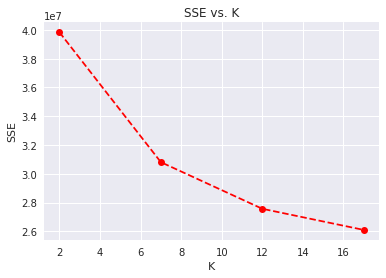

In [79]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.
plt.plot(centers, scores, linestyle='--', marker='o', color='r')
plt.xlabel('K')
plt.ylabel('SSE')
plt.title('SSE vs. K')

In [80]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
kmeans_model = KMeans(n_clusters=12).fit(azdias_pca)
population_segments = kmeans_model.predict(azdias_pca)

### Discussion 3.1: Apply Clustering to General Population

Looking at the plot I decided to cluster the data into 12 segments, because after 12 the error slope gets less steep.

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [81]:
# Load in the customer demographics data.
customers = pd.read_csv("Udacity_CUSTOMERS_Subset.csv", sep=';')

In [82]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.

In [83]:
customers = clean_data(customers)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:33: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:34: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


2.0    40259
1.0    35572
3.0     7637
Name: AGER_TYP, dtype: int64
1    104989
2     63217
Name: ANREDE_KZ, dtype: int64
6.0    45441
2.0    37699
4.0    23625
3.0    21399
1.0    21247
5.0    15993
Name: CJT_GESAMTTYP, dtype: int64
4    42446
5    41133
2    38806
6    37618
3     4610
1     3593
Name: FINANZTYP, dtype: int64
5.0     50975
10.0    23879
8.0     15433
4.0     14297
3.0     12901
7.0     12178
1.0      7757
11.0     6595
12.0     6424
6.0      5612
9.0      4878
2.0      4475
Name: GFK_URLAUBERTYP, dtype: int64
0    106547
1     61659
Name: GREEN_AVANTGARDE, dtype: int64
1.0     35828
10.0    32054
2.0     25473
11.0    19602
8.0      4124
7.0      2636
9.0      2128
5.0       780
6.0       736
4.0       490
3.0       134
Name: LP_FAMILIE_FEIN, dtype: int64
5.0    53784
1.0    35828
2.0    25473
4.0     7496
3.0     1404
Name: LP_FAMILIE_GROB, dtype: int64
10.0    47882
5.0     36666
9.0     29020
1.0     16921
3.0     13519
7.0      9267
6.0      5753
4.0      4421
2.

In [84]:
# Replace missing values with most frequent value
imputer = Imputer(strategy='most_frequent')
customers_imputed = imputer.fit_transform(customers)
customers_imputed = pd.DataFrame(customers_imputed)
customers_imputed.index = customers.index
customers_imputed.columns = customers.columns

In [85]:
customers_scaled = scaler.fit_transform(customers_imputed)
customers_scaled = pd.DataFrame(customers_scaled)
customers_scaled.index = customers.index
customers_scaled.columns = customers.columns

In [86]:
customers_pca = pca_33.fit_transform(customers_scaled)

In [87]:
customers_segments = kmeans_model.predict(customers_pca)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

In [88]:
general_cluster = {x:sum(population_segments == x)/len(population_segments) for x in range(12)}
customers_cluster = {x:sum(customers_segments == x)/len(customers_segments) for x in range(12)}

In [89]:
clusters = pd.DataFrame({'cluster': list(general_cluster.keys()), 
                          'general': list(general_cluster.values()),
                          'customer': list(customers_cluster.values())})

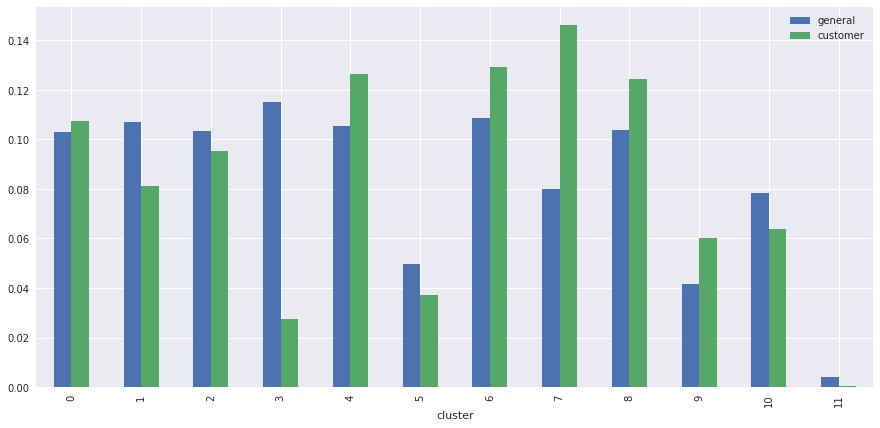

In [90]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.
clusters.plot(x='cluster', y=['general', 'customer'], kind='bar', figsize=(15,7))

In [91]:
def transform(data, kmeans, pca, scaler, centroid):
    
        centers= kmeans.cluster_centers_[centroid]
        centers_pca = pca.inverse_transform(centers)
        centers = scaler.inverse_transform(centers_pca)
        centers = pd.DataFrame(centers)
        centers.index = data.columns
        
        return centers

In [96]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?

#### Overrepresented clusters are 0, 4, 6, 7, 8, 9
centroid_0 = transform(customers_scaled, kmeans_model, pca_33, scaler, 0) 
centroid_4 = transform(customers_scaled, kmeans_model, pca_33, scaler, 4)
centroid_6 = transform(customers_scaled, kmeans_model, pca_33, scaler, 6)
centroid_7 = transform(customers_scaled, kmeans_model, pca_33, scaler, 7)
centroid_8 = transform(customers_scaled, kmeans_model, pca_33, scaler, 8)
centroid_9 = transform(customers_scaled, kmeans_model, pca_33, scaler, 9)

In [97]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?

#### Underrepresented clusters are 1, 2, 3, 5, 10, 11
centroid_1 = transform(customers_scaled, kmeans_model, pca_33, scaler, 1)
centroid_2 = transform(customers_scaled, kmeans_model, pca_33, scaler, 2)
centroid_3 = transform(customers_scaled, kmeans_model, pca_33, scaler, 3)
centroid_5 = transform(customers_scaled, kmeans_model, pca_33, scaler, 5)
centroid_10= transform(customers_scaled, kmeans_model, pca_33, scaler, 10)
centroid_11= transform(customers_scaled, kmeans_model, pca_33, scaler, 11)

In [99]:
centroid_7.T

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GEBURTSJAHR,...,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,OST_WEST_KZ_O,OST_WEST_KZ_W,generation,movement,wealth,life_stage
0,1.683472,3.730463,0.798754,5.232952,1.074584,4.622619,0.849254,1.430777,1.52162,1954.895407,...,4.166605,2.632623,4.837792,2.556588,0.093215,1.126011,3.779788,1.207989,2.076551,3.483788


In [100]:
centroid_3.T

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GEBURTSJAHR,...,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,OST_WEST_KZ_O,OST_WEST_KZ_W,generation,movement,wealth,life_stage
0,2.233113,2.177418,1.653279,2.867831,3.4251,3.07579,4.26563,3.855354,3.072447,1954.665082,...,3.036875,2.549739,4.138287,2.390073,0.142334,0.347181,3.610837,2.156445,2.826294,3.221434


### Discussion 3.3: Compare Customer Data to Demographics Data

(Double-click this cell and replace this text with your own text, reporting findings and conclusions from the clustering analysis. Can we describe segments of the population that are relatively popular with the mail-order company, or relatively unpopular with the company?)

The most overrepresented cluster in customers is cluster 7, there characteristics are:   
* 46 - 60 years old.
* Male.
* Very low financial interest.
* 300-449 buildings.  
* Older Families &  Mature Couples
* Prosperous Households. 

The most underrepresented cluster in customer is cluster 3.
* 30 - 45 years old.
* Female.
* Average financial interest.
* 130-299 buildings.
* Families With School Age Children.
* Comfortable Households.



> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.